# Exercise in Concurrency

This is an exercise to help understand the usefulness of concurrency which is very important in supercomputering as we have very large numbers of computers working _concurrently_ on the same problem.

Here we'll start with an example of concurrency on a single computer CPU that has many cores.

## Loading the needed python modules

In [19]:
import concurrent.futures
import numpy as np
import json
from PIL import Image
from itertools import repeat
import multiprocessing
import time
from matplotlib import pyplot as plt

## Retrieve ImageNet JPEG files

This is a helper function that returns a python list of image filenames.

In [20]:
# This helper function just returns a list of N image file names.
def get_image_files(config_file='ilsvrc.json', num_images = 100):
   config = json.load(open(config_file))
   filelist = config['data']['train_filelist']
   
   with open(filelist) as myfile:
      image_filenames = [next(myfile).strip() for x in range(num_images)]
   
   return image_filenames

## Process Images

We will imagine we are building a training batch for machine learning using these JPEGs. This would typically require you to
1. open the file, 
2. read the data, 
3. resize the image to fit your neural network, and
4. add it to the list of inputs

This function does this for us.

In [21]:
def process_image(image_filename, resize_shape, batch_data, index):
   # arguments:
   #   image_filename = string giving the full path to the JPEG file to open
   #   resize_shape   = a two dimensional tuple defining the image size in our batch, example: (200,100) corresponding to (width,height)
   #   batch_data     = the numpy array that will hold our batch of images in a single object with indices: (batch, width, height, channels)
   #   index          = a unique batch ID number that corresponds to the first index of our batch array
   
   # Normally, you would also add randomized transformations such as rotations, brightness changes, etc. to help make the data less dependent on the exact image.

   ## PIL is just a useful toolbox for dealing with JPEG images, such as resizing.
   # Use the PIL.Image object to open our JPEG.
   image = Image.open(image_filename)  # <- PIL.Image Object
   
   # use the Image.resize function to 
   image = image.resize(resize_shape)  # <- PIL.Image Object
   # convert the image to a numpy array
   data = np.asarray(image)            # <- numpy array of shape (width,height,3)

   # this is a check:
   # some of our JPEGs are black & white, so they have no channel index
   # so this little snippet of code adds a channel index if needed
   if len(data.shape) == 2:
      tmp = np.zeros(data.shape + (3,))
      tmp[...,0] = data
      data = tmp
   
   # In order to copy our image, which currently has shape (width,height,3)
   #    into the batch data array which has shape (batch_size,width,height,3),
   #    we need to add an extra index to our data
   data = data[np.newaxis,...]         # <- numpy array of shape (1,width,height,3)
   # copy one JPEG image data into our batch of data, at the passed index
   batch_data[index,...] = data

Now we can create a _serial_, AKA a single-core process, that builds a batch of images for our ML training.

In [22]:
# define how many images are in our batch
batch_size = 1000
# define our resize shape
resize_width = 100
resize_height = 100
resize_shape = (resize_width,resize_height) # Note tuple.
# retrieve batch_size worth of JPEG filenames
img_files = get_image_files(num_images=batch_size)
# create a numpy array that will hold our batch data
#     np.zero creates an array of the given shape
#     where all entries are set to zero
batch_data = np.zeros((batch_size,resize_width,resize_height,3))
start_time = time.time()
# loop over the image filenames and process each one.
for i,imagefile in enumerate(img_files):
   process_image(imagefile,resize_shape,batch_data,i)
end_time = time.time()
duration = end_time - start_time
print(f'duration: {duration:8.2f} seconds')
image_rate = batch_size / duration
print(f'images per second: {image_rate:8.2f}')

duration:     5.79 seconds
images per second:   172.60


The code above takes many seconds to execute and only uses 1 CPU-core to build our batch. We can speed this up using parallel threads, where each thread uses a different CPU core on our machine.

We can use Python to tell us how many CPU cores we have:

In [23]:
print('number of CPU cores on my machine: ',multiprocessing.cpu_count())

number of CPU cores on my machine:  32


Now we can rewrite the loop above using Python's `ThreadPoolExecutor` module where we specify the number of parallel threads to use and what each thread will execute. The `executor.map()` function runs a function we specify once per thread. We also must provide a list of arguments for each function call. The thread pool ENDS when it runs out of arguments to pass to the function.

In [28]:
# NEW: now we need to specify how many parallel threads to run:

# all_threads = [1, 2, 4, 8, 16, 24, 32]
all_threads = range(1, multiprocessing.cpu_count() + 1)

time_history = np.zeros(len(all_threads))
imgps_history = np.zeros(len(all_threads))
i = 0

for num_threads in all_threads:
   # num_threads = 4
   print(f'Number of threads: {num_threads}.')

   # define how many images are in our batch
   batch_size = 1000
   # define our resize shape
   resize_width = 100
   resize_height = 100
   resize_shape = (resize_width,resize_height)
   # retrieve batch_size worth of JPEG filenames
   batch_data = get_image_files(num_images=batch_size)
   # create a numpy array that will hold our batch data
   #     np.zero creates an array of the given shape
   #     where all entries are set to zero
   new_image = np.zeros((batch_size,resize_width,resize_height,3))

   start_time = time.time()

   # NEW: this is a fancy way to create this 'executor' object that will launch and manage our parallel threads.
   # This TPE will take an argument for max, and will fill workers up to max (but may not, if there's not enough work.)
   with concurrent.futures.ThreadPoolExecutor(max_workers=num_threads) as executor:
      # map() allows you to use the function handle and apply it to all the image files in the batch. If the executor can fill all the workers with batches, it will do so, and then keep replacing workers with new arguments until it runs out of batch_data to pass to workers.

      # Here is where the actual threads are launched
      #   we pass the function each thread should call 'process_image'
      #   then we pass our input function arguments:
      #        batch_data  -> a list of filenames (batch_size long)
      #        repeat(resize_shape) -> repeat will provide as many copies of the resize_shape as is needed
      #        repeat(new_image) -> repeat will provide as many copies of the new_image as is needed
      #        repeat(len(img_files)) -> repeat will provide as many copies of number of files as is needed
      results = executor.map(process_image, batch_data, repeat(resize_shape), repeat(new_image), range(len(batch_data)))

   end_time = time.time()
   duration = end_time - start_time

   print(f'duration: {duration:8.2f} seconds')
   image_rate = batch_size / duration
   print(f'images per second: {image_rate:8.2f}')
   print(f'images per core per second: {image_rate/num_threads:8.2f}')

   time_history[i] = duration
   imgps_history[i] = image_rate
   i += 1

Number of threads: 1.
duration:     6.76 seconds
images per second:   148.02
images per core per second:   148.02
Number of threads: 2.
duration:     3.17 seconds
images per second:   315.82
images per core per second:   157.91
Number of threads: 3.
duration:     2.15 seconds
images per second:   464.39
images per core per second:   154.80
Number of threads: 4.
duration:     1.72 seconds
images per second:   582.02
images per core per second:   145.50
Number of threads: 5.
duration:     1.39 seconds
images per second:   719.33
images per core per second:   143.87
Number of threads: 6.
duration:     1.15 seconds
images per second:   866.37
images per core per second:   144.39
Number of threads: 7.
duration:     1.09 seconds
images per second:   916.82
images per core per second:   130.97
Number of threads: 8.
duration:     0.96 seconds
images per second:  1043.67
images per core per second:   130.46
Number of threads: 9.
duration:     0.85 seconds
images per second:  1180.99
images per 

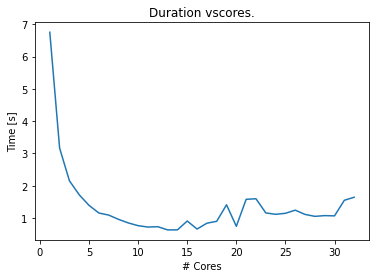

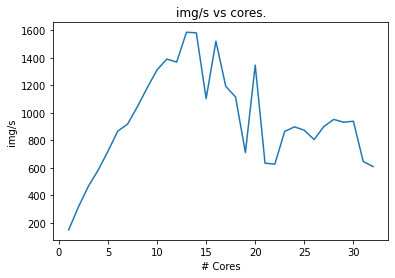

In [29]:
plt.figure()
plt.tight_layout()
plt.title('Duration vscores.')
plt.xlabel('# Cores')
plt.ylabel('Time [s]')
plt.plot(all_threads, time_history)

plt.figure()
plt.tight_layout()
plt.title('img/s vs cores.')
plt.xlabel('# Cores')
plt.ylabel('img/s')
plt.plot(all_threads, imgps_history)

In [26]:
# you can check the results of each thread using the list of "results" returned by the map
# though in our case, they should simply be None since our function has no return value
for result in results:
   if result is not None: print(result)


# Exersize Instructions

Play with the value of `num_threads` and note how it affects run time and throughput. How does the return value of `multiprocessing.cpu_count()`, that is, how does the number of CPU cores on your machine impact the throughput you can achieve?

Number of threads: 1.

duration:     5.81 seconds

images per second:   172.24

images per core per second:   172.24

Number of threads: 2.

duration:     3.38 seconds

images per second:   296.20

images per core per second:   148.10

Number of threads: 4.

duration:     1.71 seconds

images per second:   583.90

images per core per second:   145.98

Number of threads: 8.

duration:     0.93 seconds

images per second:  1071.34

images per core per second:   133.92

Number of threads: 16.

duration:     0.75 seconds

images per second:  1338.53

images per core per second:    83.66

Number of threads: 24.

duration:     1.16 seconds

images per second:   865.17

images per core per second:    36.05

Number of threads: 32.

duration:     1.20 seconds

images per second:   830.60

images per core per second:    25.96



So interestingly, the optimal point for this dataset is not to use all available cores: 32 cores perform only marginally better than 4, and worse than 8. For optimal images/core/s, 4 cores is the best. In terms of total throughput, 16 cores is the best.